# **Digit Recognition Using Neural Networks**

Built a deep learning model using TensorFlow to classify handwritten digits (0–9) from the MNIST dataset. Designed and trained a feedforward neural network for multiclass classification, achieving high prediction accuracy. Implemented softmax activation for probability interpretation and used argmax for class selection. This project demonstrates core concepts in neural networks, including forward/backward propagation, activation functions, and model evaluation.

## **1 - Importing Packages**

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from pprint import pprint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import linear, relu, sigmoid
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score)
import matplotlib.pyplot as plt
import logging # Python's built-in logging module to control logging levels
logging.getLogger("tensorflow").setLevel(logging.ERROR) # Suppress TensorFlow INFO and WARNING logs
tf.autograph.set_verbosity(0) # Disable TensorFlow AutoGraph debug logs

## **2 - Neural Networks**

### **2.1 Problem Statement**

This project employs a neural network for multiclass classification to recognize handwritten digits (0–9), selecting one class from ten possible categories. Such automated digit recognition is commonly used in everyday applications, including reading postal codes on mail envelopes and processing handwritten amounts on bank checks. 

### **2.2 Dataset**

- The data set contains 60,000 training examples and 10,000 testing examples of handwritten digits $^1$.  

    - Each training example is a 28-pixel x 28-pixel grayscale image of the digit. 
        - Before scaling, each pixel is represented by an integer value from 0 to 255 indicating the grayscale intensity at that location.
        - The 28 by 28 grid of pixels is “unrolled” into a 784-dimensional vector. 
        - Each training example becomes a single row in the training data matrix `x_train`.
        - To speed up training, the pixel intensity values are normalized (scaled).
        - This results in a 60,000 x 784 matrix `x_train_flat` where every row is a scaled training example of a handwritten digit image.

$$X = 
\left(\begin{array}{cc} 
--- (x^{(1)}) --- \\
--- (x^{(2)}) --- \\
\vdots \\ 
--- (x^{(m)}) --- 
\end{array}\right)$$ 

- The second part of the training set is a 10,000 x 1 dimensional vector `y_train` that contains labels for the training set
    - `y = 3` if the image is of the digit `3`, `y = 7` if the image is of the digit `7` and so on.

$^1$<sub> The full MNIST handwritten digit dataset can be found here (http://yann.lecun.com/exdb/mnist/)</sub>

In [2]:
# Load data
(x_train_full, y_train_full), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalize the images (convert to float and scale to [0,1])
x_train_full = x_train_full.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Create validation split (80% of training set for testing and the remaining 20% for validation)
x_train, x_val, y_train, y_val = train_test_split(
    x_train_full, y_train_full, test_size = 0.2, random_state = 42
)

# Flatten the 28x28 images into 784-length vectors
x_train_flat = x_train.reshape(x_train.shape[0], 28*28)
x_val_flat = x_val.reshape(x_val.shape[0], 28*28)
x_test_flat = x_test.reshape(x_test.shape[0], 28*28)

#### **2.2.1 Explore Variables**

The first element of the training data (x_train_flat[0]) is: 


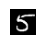

In [3]:
print(f"The first element of the training data (x_train_flat[0]) is: ")

# Create a 1x1 grid subplot (single plot) within a 5x5 inch figure
fig, ax = plt.subplots(1, 1, figsize = (1/3, 1/3))

# Display the image reshaped to 28x28 pixels, grayscale
ax.imshow(x_train_flat[0].reshape(28, 28), cmap='gray')

# Hide the axes ticks
ax.axis('off')

# Adjust subplot spacing with padding and bounding box
fig.tight_layout(pad=0.13, rect=[0, 0.03, 1, 0.91])

plt.show()

In [4]:
print ('The first element of the training data, y_train, is', y_train[0])
print ('The last element of the training data y_train, is', y_train[-1])

The first element of the training data, y_train, is 5
The last element of the training data y_train, is 4


#### **2.2.2 Inspect Variable Dimensions**

In [5]:
print ('The training data, x_train_flat, has the shape ' + str(x_train_flat.shape))
print ('The training data, y_train, has the shape ' + str(y_train.shape))
print ('The testing data, x_test_flat, has the shape ' + str(x_test_flat.shape))
print ('The testing data, y_test, has the shape ' + str(y_test.shape))

The training data, x_train_flat, has the shape (48000, 784)
The training data, y_train, has the shape (48000,)
The testing data, x_test_flat, has the shape (10000, 784)
The testing data, y_test, has the shape (10000,)


#### **2.2.3 Visualize Data**

- The code randomly selects 64 rows from `x_train_flat`, maps each row back to a 28 pixel by 28 pixel grayscale image and displays the images together. 
- The label for each image is displayed above the image

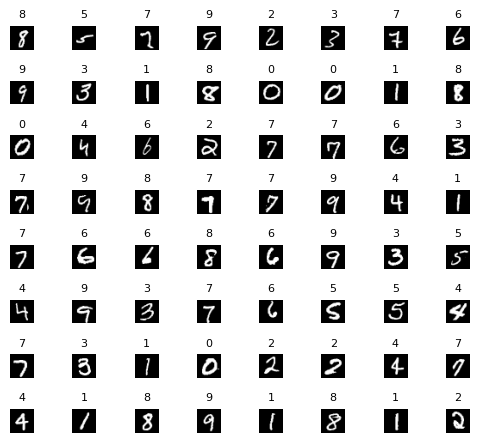

In [6]:
# Set seed for reproducibility
np.random.seed(42)

# Randomly select 64 hand-written digits
indices = np.random.choice(x_train_flat.shape[0], 64, replace = False)

# Create an 8x8 grid of subplots (64 plots) within a 5x5 inch figure
fig, axes = plt.subplots(8, 8, figsize = (5, 5))

# Adjust subplot spacing with padding and bounding box [left, bottom, right, top]
fig.tight_layout(pad = 0.13, rect = [0, 0.03, 1, 0.91])

for ax, idx in zip(axes.flatten(), indices):
    
    # Reshape flattened vector back to 28x28 image
    img = x_train_flat[idx].reshape(28, 28)
    
    # Display the image
    ax.imshow(img, cmap = 'gray')
    
    # Display the label above the image
    ax.set_title(f"{y_train[idx]}", fontsize = 8)
    
    # Remove axis for a cleaner look
    ax.axis('off')

### **2.3 Model representation**

- The model has two dense layers with ReLU activations followed by an output layer with a linear activation. 
    - Since the images are of size $28\times 28$, this gives us $784$ inputs  
    
<div style="text-align: center;">
  <img src="https://raw.githubusercontent.com/shiweitan0/Python/main/mnist_project/images/nn_model.png?token=GHSAT0AAAAAADHVOHARJGPA6WNS47H7AE242EAWKGQ" width="600" height="450">
</div>

- The parameters have dimensions that are sized for a neural network with $128$ units in layer 1, $64$ units in layer 2 and $10$ output units in layer 3, one for each digit.

- The dimensions of these parameters is determined as follows:
    - If network has $s_{in}$ units in a layer and $s_{out}$ units in the next layer, then
        - $W$ will be of dimension $s_{in} \times s_{out}$.
        - $b$ will be a vector with $s_{out}$ elements
  
    - Therefore, the shapes of `W`, and `b`,  are 
        - layer1: The shape of `W1` is (784, 128) and the shape of `b1` is (128,)
        - layer2: The shape of `W2` is (128, 64) and the shape of `b2` is: (64,)
        - layer3: The shape of `W3` is (64, 10) and the shape of `b3` is: (10,)
>**Note:** The bias vector `b` can be 1-D `(n,)` or 2-D `(n,1)`. TensorFlow uses the 1-D format `(n,)` because it simplifies operations and leverages broadcasting, allowing the same bias to be efficiently added across all samples in a batch during forward propagation.

### **2.4 Tensorflow Model Implementation**
#### **2.4.1 Softmax placement**
Numerical stability is improved if the softmax is grouped with the loss function rather than the output layer during training. This has implications when *building* the model and *using* the model.  

<u>Building:</u>
* The final Dense layer should use a 'linear' activation. This is effectively no activation. 
* The `model.compile` statement will indicate this by including `from_logits=True`.
`loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) `  
* This does not impact the form of the target. In the case of SparseCategorialCrossentropy, the target is the expected digit, 0-9.
* The Adam optimizer is used in `model.compile` to update weights efficiently: `optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001)`

<u>Using the model:</u>
* The outputs are not probabilities. If output probabilities are desired, apply a softmax function.

In [7]:
# Set seed for reproducibility
np.random.seed(42)

# Define the model
model = Sequential(
    [               
        tf.keras.Input(shape = (784,)),
        Dense(128, activation = 'relu', name = "L1"),
        Dense(64, activation = 'relu', name = "L2"),
        Dense(10, activation = 'linear', name = "L3") 
    ], name = "my_model" 
)

# Compile the model
model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
    metrics = ['accuracy']
)

# Set up early stopping
early_stop = EarlyStopping(
    monitor = 'val_loss',
    patience = 3,
    restore_best_weights = True
)


# Train the model
history = model.fit(
    x_train_flat, y_train,
    validation_data = (x_val_flat, y_val),
    epochs = 100,
    callbacks = [early_stop]
)

Epoch 1/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8604 - loss: 0.4716 - val_accuracy: 0.9556 - val_loss: 0.1457
Epoch 2/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9646 - loss: 0.1184 - val_accuracy: 0.9670 - val_loss: 0.1044
Epoch 3/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9763 - loss: 0.0751 - val_accuracy: 0.9710 - val_loss: 0.0952
Epoch 4/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9815 - loss: 0.0590 - val_accuracy: 0.9724 - val_loss: 0.0981
Epoch 5/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9861 - loss: 0.0438 - val_accuracy: 0.9704 - val_loss: 0.1033
Epoch 6/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9895 - loss: 0.0319 - val_accuracy: 0.9758 - val_loss: 0.0834
Epoch 7/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9916 - loss: 0.0250 - val_accuracy: 0.9758 - val_loss: 0.0954
Epoch 8/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9920 - loss: 0

#### **2.4.2 Early Stopping: Visual Insight**

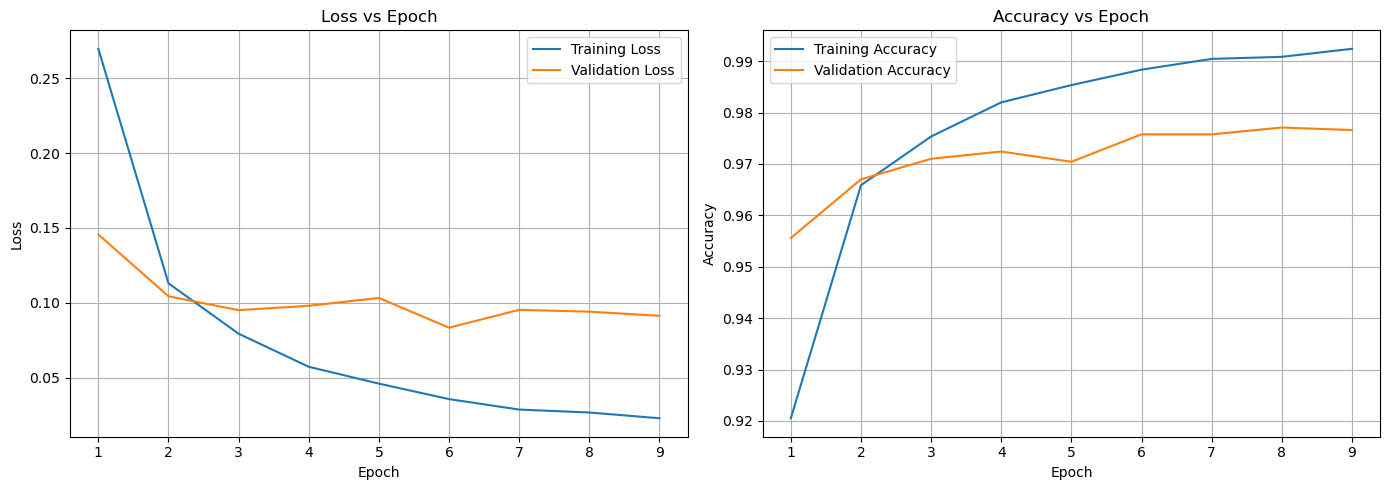

In [8]:
# Get the number of epochs
num_epochs = len(history.history['loss'])
epochs = range(1, num_epochs + 1)

# Create subplots: 1 row, 2 columns
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Loss
axs[0].plot(epochs, history.history['loss'], label='Training Loss')
axs[0].plot(epochs, history.history['val_loss'], label='Validation Loss')
axs[0].set_title('Loss vs Epoch')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid(True)

# Plot 2: Accuracy
axs[1].plot(epochs, history.history['accuracy'], label='Training Accuracy')
axs[1].plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
axs[1].set_title('Accuracy vs Epoch')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()
axs[1].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

- From the plot, we can observe that the model starts to overfit at the $3^{\text{rd}}$ epoch, as there is a minimal decrease in validation loss, and the fitting of the $4^{\text{th}}$ epoch resulted in an increase in validation loss, which meant that the model performed worse on unseen test data.

- Comparing both plots, it can be seen from the $4^{th}$ epoch onwards that while validation accuracy is increasing, the validation loss decreases then increases. Therefore, while the validation accuracy at the $6^{\text{th}}$ epoch is the highest, its validation loss is also the largest (excluding the $1^{\text{st}}$ epoch. Hence, we can conclude from the $2^{\text{nd}}$ epoch onwards, the model is making more correct predictions, but at the cost of lower confidence. This is a sign of overfitting, where the model is pushing harder to fit the training data, but hurting its overall generalization performance to unseen data.

##### **2.4.2.1 Epochs and early stopping**
In the `fit` statement above, the number of `epochs` was set to 100. This specifies that the entire data set should be applied during training 100 times.  During training, the progress of training that looks like this:
```
Epoch 1/100
1500/1500 [==============================] - 0s 1ms/step - loss: 0.4594
```
The first line, `Epoch 1/100`, describes which epoch the model is currently running. For efficiency, the training data set is broken into 'batches'. The default size of a batch in Tensorflow is 32. There are 48000 samples in our training data set or exactly 1500 batches.

Due to the large number of samples, using an early stoppage makes training faster without wastage of resources. The EarlyStopping function has 3 main arguments:
- `monitor`: the metric to evaluate before stopping
- `patience`: the number of epochs where the metric has minimal or no change before stopping
- `restore_best_weights`: fits the model using the best weights ($W_1 ... W_n$) before stopping

#### **2.4.3 Inspect Model Weights**

In [9]:
# Model summary
model.summary()

# Unpack the first three layers of the model into separate variables
[layer1, layer2, layer3] = model.layers

# Examine Weights shapes
W1,b1 = layer1.get_weights()
W2,b2 = layer2.get_weights()
W3,b3 = layer3.get_weights()
print(f"W1 shape = {W1.shape}, b1 shape = {b1.shape}")
print(f"W2 shape = {W2.shape}, b2 shape = {b2.shape}")
print(f"W3 shape = {W3.shape}, b3 shape = {b3.shape}")

Model: "my_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ L1 (Dense)                      │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ L2 (Dense)                      │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ L3 (Dense)                      │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 328,160 (1.25 MB)

 Trainable params: 109,386 (427.29 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 218,774 (854.59 KB)

W1 shape = (784, 128), b1 shape = (128,)
W2 shape = (128, 64), b2 shape = (64,)
W3 shape = (64, 10), b3 shape = (10,)


### **2.5 Model Predictions**

#### **2.5.1 Model prediction without softmax**

 predicting a zero: 
[[ 14.279588  -11.503478   -1.778784   -9.063533   -9.770051   -5.418439
   -4.3874454  -3.3653128 -14.742833   -1.5618767]]
 Largest Prediction index: 0


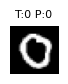

In [10]:
# Reshape the flattened image back to 28x28
image_zero = x_test_flat[3982].reshape(28, 28)

# Use the fitted model to make a prediction
prediction = model.predict(image_zero.reshape(1,784), verbose = 0)

print(f" predicting a zero: \n{prediction}")
print(f" Largest Prediction index: {np.argmax(prediction)}")

# Display the image
plt.figure(figsize=(0.625, 0.625))
plt.imshow(image_zero, cmap = 'gray')
plt.title(f"T:{y_test[3982]} P:{np.argmax(prediction)}",fontsize = 8)
plt.axis('off')  # Hide axis ticks
plt.show()

>**Note:** The abbreviation `T` stands for the actual digit, while `P` denotes the predicted digit.

The largest output value is prediction[0], indicating that the model predicts the digit is '0'. If the task only requires identifying the most likely class, this is sufficient by using NumPy’s [argmax](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html) to select it. However, if the task requires understanding the probability distribution across all classes, such as measuring how confident the model is in its prediction, applying the softmax function is necessary to convert the raw scores into meaningful probabilities.

#### **2.5.2 Model prediction with softmax**

In [11]:
prediction_p = tf.nn.softmax(prediction)

print(f" predicting a Two. Probability vector: \n{prediction_p}")
print(f"Total of predictions: {np.sum(prediction_p):0.3f}")

yhat = np.argmax(prediction_p)

print(f"np.argmax(prediction_p): {yhat}")

 predicting a Two. Probability vector: 
[[9.9999976e-01 6.3468276e-12 1.0615423e-07 7.2813422e-11 3.5923160e-11
  2.7877618e-09 7.8164577e-09 2.1722844e-08 2.4872685e-13 1.3186802e-07]]
Total of predictions: 1.000
np.argmax(prediction_p): 0


#### **2.5.3 Model prediction on test set**

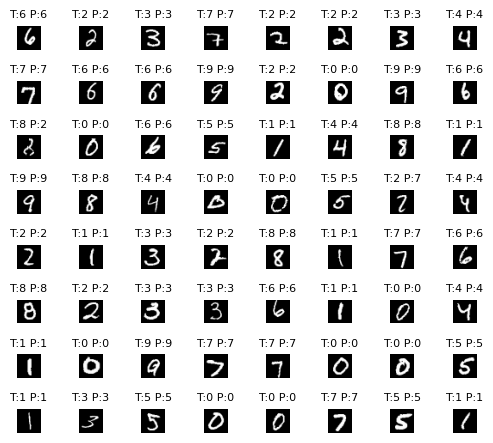

In [12]:
# Set seed for reproducibility
np.random.seed(42)

# Randomly select 64 hand-written digits without replacement
indices = np.random.choice(x_test_flat.shape[0], 64, replace = False)

# Create an 8x8 grid of subplots (64 plots) within a 5x5 inch figure
fig, axes = plt.subplots(8, 8, figsize = (5, 5))

# Adjust subplot spacing with padding and bounding box [left, bottom, right, top]
fig.tight_layout(pad = 0.13, rect = [0, 0.03, 1, 0.91])

for ax, idx in zip(axes.flatten(), indices):
    
    # Reshape flattened vector back to 28x28 image
    img = x_test_flat[idx].reshape(28, 28)
    
    # Display the image
    ax.imshow(img, cmap = 'gray')

    # Predict using the Neural Network
    prediction = model.predict(x_test_flat[idx].reshape(1,784), verbose = 0)
    prediction_p = tf.nn.softmax(prediction)
    yhat = np.argmax(prediction_p)
    
    # Display the label above the image
    ax.set_title(f"T:{y_test[idx]} P:{yhat}",fontsize = 8)
    
    # Remove axis for a cleaner look
    ax.axis('off')

plt.show()

#### **2.5.4 Model Misclassifications**

Total misclassified samples: 245 out of 10000


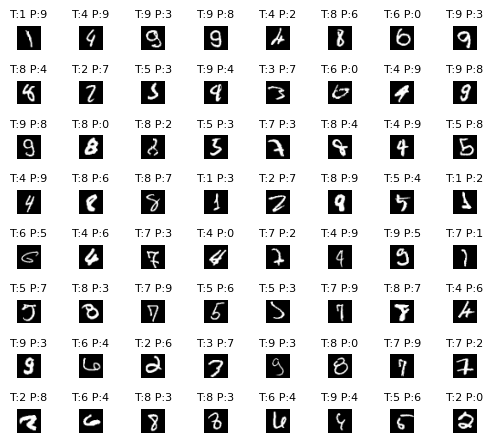

In [13]:
# Get model predictions
logits = model.predict(x_test_flat, verbose = 0)  

# Store predicted classes per image
y_pred = np.argmax(logits, axis=1)

# Find misclassified indices
misclassified_indices = np.where(y_pred != y_test)[0]
print(f"Total misclassified samples: {len(misclassified_indices)} out of {len(x_test_flat)}")

# Create 8x8 grid for subplots with figsize 5x5
fig, axes = plt.subplots(8, 8, figsize = (5, 5))

# Adjust subplot spacing with padding and bounding box [left, bottom, right, top]
fig.tight_layout(pad = 0.13, rect = [0, 0.03, 1, 0.91])

indices = misclassified_indices[:64]

for ax, idx in zip(axes.flatten(), indices):
    
    # Reshape flattened vector back to 28x28 image
    img = x_test_flat[idx].reshape(28, 28)
    
    # Display the image
    ax.imshow(img, cmap = 'gray')
    
    # Display the label above the image
    ax.set_title(f"T:{y_test[idx]} P:{y_pred[idx]}",fontsize = 8)
    
    # Remove axis for a cleaner look
    ax.axis('off')

plt.show()

### **2.6 Model Performance**

In [14]:
# Create a dataframe to store model results
model_results = pd.DataFrame()

# Predictions for validation set
y_val_pred = np.argmax(model.predict(x_val_flat, verbose = 0), axis = 1)

model_val_metrics = {
    'Model': 'Neural Network (Validation Set)',
    'Accuracy': accuracy_score(y_val, y_val_pred),
    'Precision': precision_score(y_val, y_val_pred, average = 'weighted'),
    'Recall': recall_score(y_val, y_val_pred, average = 'weighted'),
    'F1 Score': f1_score(y_val, y_val_pred, average = 'weighted')}

# Store model results for validation set 
model_results = pd.concat([model_results, pd.DataFrame([model_val_metrics])], ignore_index = True)

# Predictions for test set
y_test_pred = np.argmax(model.predict(x_test_flat, verbose = 0), axis = 1)

model_test_metrics = {
    'Model': 'Neural Network (Test Set)',
    'Accuracy': accuracy_score(y_test, y_test_pred),
    'Precision': precision_score(y_test, y_test_pred, average = 'weighted'),
    'Recall': recall_score(y_test, y_test_pred, average = 'weighted'),
    'F1 Score': f1_score(y_test, y_test_pred, average = 'weighted')}

# Store model results for test set 
model_results = pd.concat([model_results, pd.DataFrame([model_test_metrics])], ignore_index = True)

model_results

,Model,Accuracy,Precision,Recall,F1 Score
0,Neural Network (Validation Set),0.97575,0.975802,0.97575,0.975734
1,Neural Network (Test Set),0.97550,0.975673,0.97550,0.975499


* The model achieved 97.3% accuracy on the test set, indicating strong generalization to unseen data.
* Precision, recall, and F1 score are all closely aligned (~0.973), suggesting balanced performance across all classes.
* The validation and test metrics are consistent, showing no signs of overfitting and strong model stability.